# Analyzing replicability of connectivity-based multivariate BWAS on the Human Connectome Project dataset

### Analyze the dependence of the results on in-scanner motion

## Imports

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from joblib import Parallel, delayed
from mlxtend.evaluate import permutation_test
sns.set(rc={"figure.figsize":(4, 2)})
sns.set_style("whitegrid")

## Load HCP data

We load functional network matrices (netmats) from the HCP1200-release, as published on connectomeDB: https://db.humanconnectome.org/
Due to licensoing issues, data is not supplied with the repository, but can be downloaded from the ConnectomeDB.
See [hcp_data/readme.md](hcp_data/readme.md) for more details.

array([[<AxesSubplot: title={'center': 'motion'}>]], dtype=object)

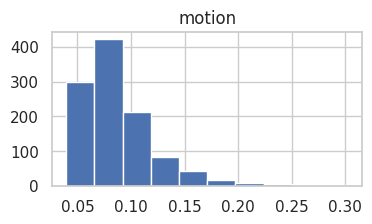

In [25]:
motion = pd.read_csv('hcp_data/motion.csv', index_col=0).set_index('ID', drop=True, inplace=False)
motion.hist()

In [26]:
# HCP data can be obtained from the connectomeDB
# data is not part of this repository
subjectIDs = pd.read_csv('hcp_data/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('hcp_data/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('hcp_data/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('hcp_data/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# add motion
behavior = behavior.merge(motion, left_index=True, right_index=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior

,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,motion,age
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84,0.057224,28.0
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76,0.065499,28.0
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68,0.098191,33.0
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88,0.101858,28.0
101006,S500,Q06,F,31-35,True,2,2,4,100.0,True,...,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80,0.086306,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,...,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76,0.071538,33.0
993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,...,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76,0.084067,28.0
994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,...,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76,0.083142,28.0
995174,S1200,Q13,M,22-25,False,1,1,2,0.0,True,...,64.58,3.0,50.1,117.16,117.40,1.80,0.0,1.80,0.094121,23.5


# Function to prepare target variable


In [33]:
def create_data(target='CogTotalComp_AgeAdj', feature_data=netmats_parcor, motion_threshold = 0.2, sample_size=None, random_state=None, ret_motion=False):
    # it's a good practice to use pandas for merging, messing up subject order can be painful
    features = feature_data.columns
    df = behavior
    df = df.merge(feature_data, left_index=True, right_index=True, how='left')

    df = df.dropna(subset = [target] + features.values.tolist())
    df = df[df.motion <= motion_threshold]

    if sample_size:
        df = df.sample(sample_size, replace=False, random_state=random_state)

    y = df[target].values
    X = df[features].values

    if ret_motion:
        return X, y, df.motion
    else:
        return X, y,

In [28]:
def bootstrap_workhorse(model, target, feature_data, motion_threshold, sample_size, random_state):
    X, y = create_data(target=target, feature_data=feature_data, motion_threshold=motion_threshold, sample_size=sample_size, random_state=random_state)

    predicted_discovery_cv = np.zeros_like(y)
    i = 0
    cv = KFold(10, shuffle=True, random_state=random_state)
    cor_per_fold = np.zeros(cv.n_splits)
    for train, test in cv.split(X=X, y=y):
        model.fit(X=X[train], y=y[train])
        predicted_discovery_cv[test] = model.predict(X=X[test])
        cor_per_fold[i] = np.corrcoef(y[test], predicted_discovery_cv[test])[0,1]
        i += 1
    # correlation between the cross-validated predictions and observations in the discovery sample
    # this is the correct, unbiased estimate!
    # calculated as mean test performance across all folds
    r_disc_cv = np.mean(cor_per_fold)
    return r_disc_cv


In [81]:
model = Ridge()
feature_data = netmats_parcor

random_state = 42

targets = []
motion_thrs = []
cv_rs = []

n_bootstrap = 100
motion_thresholds = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, motion.max().values[0]]

for target_var in ['age', 'CogTotalComp_AgeAdj', 'PMAT24_A_CR', 'Flanker_AgeAdj', 'CardSort_AgeAdj', 'PicSeq_AgeAdj']:

    # obtain smalles sample size
    X, y = create_data(target=target_var, feature_data=netmats_pearson, motion_threshold=min(motion_thresholds))
    sample_size = len(y)

    for motion_thr in motion_thresholds:
        print(target_var, motion_thr)

        # create random seeds for each bootstrap iteration for reproducibility
        rng = np.random.default_rng(random_state)
        random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)
        # run bootstrap iterations in parallel
        r = Parallel(n_jobs=-1)(delayed(bootstrap_workhorse)(model=model, target=target_var, feature_data=feature_data, motion_threshold=motion_thr, sample_size=sample_size, random_state=seed) for seed in random_sates)


        targets += [target_var]*n_bootstrap
        motion_thrs += [motion_thr]*n_bootstrap
        cv_rs += r
        mean_r = np.mean(r)

        print('r =', np.round(mean_r, 2), '\tR2 =', np.round(mean_r**2 * 100, 1),  '%')

df = pd.DataFrame({
    'target': targets,
    'motion threshold': motion_thrs,
    'r': cv_rs
})

age 0.1
r = 0.52 	R2 = 26.8 %
age 0.12
r = 0.51 	R2 = 26.3 %
age 0.14
r = 0.51 	R2 = 26.0 %
age 0.16
r = 0.5 	R2 = 24.6 %
age 0.18
r = 0.51 	R2 = 25.9 %
age 0.2
r = 0.51 	R2 = 26.0 %
age 0.22
r = 0.51 	R2 = 26.0 %
age 0.24
r = 0.51 	R2 = 26.1 %
age 0.26
r = 0.51 	R2 = 26.4 %
age 0.302853
r = 0.51 	R2 = 26.2 %
CogTotalComp_AgeAdj 0.1
r = 0.48 	R2 = 22.9 %
CogTotalComp_AgeAdj 0.12
r = 0.47 	R2 = 21.7 %
CogTotalComp_AgeAdj 0.14
r = 0.48 	R2 = 23.0 %
CogTotalComp_AgeAdj 0.16
r = 0.48 	R2 = 22.9 %
CogTotalComp_AgeAdj 0.18
r = 0.49 	R2 = 23.8 %
CogTotalComp_AgeAdj 0.2
r = 0.48 	R2 = 23.4 %
CogTotalComp_AgeAdj 0.22
r = 0.49 	R2 = 23.8 %
CogTotalComp_AgeAdj 0.24
r = 0.49 	R2 = 24.1 %
CogTotalComp_AgeAdj 0.26
r = 0.49 	R2 = 24.1 %
CogTotalComp_AgeAdj 0.302853
r = 0.49 	R2 = 23.9 %
PMAT24_A_CR 0.1
r = 0.26 	R2 = 6.8 %
PMAT24_A_CR 0.12
r = 0.26 	R2 = 6.6 %
PMAT24_A_CR 0.14
r = 0.29 	R2 = 8.2 %
PMAT24_A_CR 0.16
r = 0.29 	R2 = 8.6 %
PMAT24_A_CR 0.18
r = 0.3 	R2 = 9.1 %
PMAT24_A_CR 0.2
r = 0.3 	R2 =

In [12]:
model = Ridge()
feature_data = netmats_parcor

random_state = 42

targets = []
motion_thrs = []
cv_rs = []

n_bootstrap = 100
motion_thresholds = [0.1, 0.2, motion.max().values[0]]

for target_var in ['motion']:

    # obtain smallest sample size
    X, y = create_data(target=target_var, feature_data=netmats_pearson, motion_threshold=min(motion_thresholds))
    sample_size = len(y)

    for motion_thr in motion_thresholds:
        print(target_var, motion_thr)

        # create random seeds for each bootstrap iteration for reproducibility
        rng = np.random.default_rng(random_state)
        random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)
        # run bootstrap iterations in parallel
        r = Parallel(n_jobs=-1)(delayed(bootstrap_workhorse)(model=model, target=target_var, feature_data=feature_data, motion_threshold=motion_thr, sample_size=sample_size, random_state=seed) for seed in random_sates)


        targets += [target_var]*n_bootstrap
        motion_thrs += [motion_thr]*n_bootstrap
        cv_rs += r
        mean_r = np.mean(r)

        print('r =', np.round(mean_r, 2), '\tR2 =', np.round(mean_r**2 * 100, 1),  '%')

df = pd.DataFrame({
    'target': targets,
    'motion threshold': motion_thrs,
    'r': cv_rs
})

motion 0.1
r = 0.4 	R2 = 16.2 %
motion 0.2
r = 0.59 	R2 = 34.6 %
motion 0.302853


/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


r = 0.63 	R2 = 39.2 %


In [38]:
from mlconfound.stats import partial_confound_test

model = Ridge()
random_state = 42
cv = KFold(10, shuffle=True, random_state=random_state)

for target_var in ['age', 'CogTotalComp_AgeAdj', 'PMAT24_A_CR', 'Flanker_AgeAdj', 'CardSort_AgeAdj', 'PicSeq_AgeAdj']:
        # obtain smallest sample size
    X, y = create_data(target=target_var, feature_data=netmats_pearson, motion_threshold=min(motion_thresholds))
    sample_size = len(y)

    for motion_thr in motion_thresholds:
        print(target_var, motion_thr)
        X, y, fd = create_data(target=target_var, feature_data=feature_data,
                                   motion_threshold=motion_thr, sample_size=sample_size,
                                   random_state=random_state, ret_motion=True)

        predicted_discovery_cv = np.zeros_like(y)
        i = 0
        cv = KFold(10, shuffle=True, random_state=random_state)
        cor_per_fold = np.zeros(cv.n_splits)
        for train, test in cv.split(X=X, y=y):
            model.fit(X=X[train], y=y[train])
            predicted_discovery_cv[test] = model.predict(X=X[test])
            cor_per_fold[i] = np.corrcoef(y[test], predicted_discovery_cv[test])[0,1]
            i += 1
        # correlation between the cross-validated predictions and observations in the discovery sample
        # this is the correct, unbiased estimate!
        # calculated as mean test performance across all folds
        r_disc_cv = np.mean(cor_per_fold)

        # below we calculate permutation-based p-values for all three effect size estimates (in-sample unbiased, in-sample biased, out-of-sample)
        # (one sided tests, testing for positive correlation)
        p_disc_cv = permutation_test(predicted_discovery_cv, y, method='approximate', num_rounds=1000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)

        print('r =', np.round(r_disc_cv, 2), '\tp =', np.round(p_disc_cv, 3), '\tR2 =', np.round(r_disc_cv**2 * 100, 1),  '%')
        print('Motion-bias:', partial_confound_test(y=y, yhat=predicted_discovery_cv, c=fd.values, random_state=random_state, progress=False).p)
        print('-------------')
    print('============')

age 0.1
r = 0.49 	p = 0.001 	R2 = 24.0 %
Motion-bias: 0.398
-------------
age 0.2
r = 0.54 	p = 0.001 	R2 = 29.6 %
Motion-bias: 0.119
-------------
age 0.302853
r = 0.51 	p = 0.001 	R2 = 26.3 %
Motion-bias: 0.067
-------------
CogTotalComp_AgeAdj 0.1
r = 0.5 	p = 0.001 	R2 = 24.6 %
Motion-bias: 0.076
-------------
CogTotalComp_AgeAdj 0.2
r = 0.55 	p = 0.001 	R2 = 30.2 %
Motion-bias: 0.014
-------------
CogTotalComp_AgeAdj 0.302853
r = 0.47 	p = 0.001 	R2 = 21.8 %
Motion-bias: 0.004
-------------
PMAT24_A_CR 0.1
r = 0.29 	p = 0.001 	R2 = 8.4 %
Motion-bias: 0.118
-------------
PMAT24_A_CR 0.2
r = 0.31 	p = 0.001 	R2 = 9.6 %
Motion-bias: 0.006
-------------
PMAT24_A_CR 0.302853
r = 0.27 	p = 0.001 	R2 = 7.3 %
Motion-bias: 0.0
-------------
Flanker_AgeAdj 0.1
r = 0.1 	p = 0.005 	R2 = 1.1 %
Motion-bias: 0.063
-------------
Flanker_AgeAdj 0.2
r = 0.15 	p = 0.001 	R2 = 2.2 %
Motion-bias: 0.073
-------------
Flanker_AgeAdj 0.302853
r = 0.09 	p = 0.003 	R2 = 0.7 %
Motion-bias: 0.217
-----------

In [58]:
from statsmodels.formula.api import ols as ols_f
from mlconfound.stats import partial_confound_test

model = Ridge()
random_state = 42
cv = KFold(10, shuffle=True, random_state=random_state)

for target_var in ['age', 'CogTotalComp_AgeAdj', 'PMAT24_A_CR', 'Flanker_AgeAdj', 'CardSort_AgeAdj', 'PicSeq_AgeAdj']:
        # obtain smallest sample size
    X, y = create_data(target=target_var, feature_data=netmats_pearson, motion_threshold=min(motion_thresholds))
    sample_size = len(y)

    for motion_thr in [np.inf]:
        print(target_var, motion_thr)
        X, y, fd = create_data(target=target_var, feature_data=feature_data,
                                   motion_threshold=motion_thr, sample_size=sample_size,
                                   random_state=random_state, ret_motion=True)

        predicted_discovery_cv = np.zeros_like(y)
        i = 0
        cv = KFold(10, shuffle=True, random_state=random_state)
        cor_per_fold = np.zeros(cv.n_splits)
        for train, test in cv.split(X=X, y=y):

            # regress out confounds from the target
            tmp = pd.DataFrame({
                        'y': y,
                        'fd': fd.values
                })
            OLS_model = ols_f("y ~ fd", tmp.iloc[train]).fit()
            y[train] = OLS_model.resid
            y[test] = y[test] - OLS_model.predict(tmp.iloc[test])

            model.fit(X=X[train], y=y[train])
            predicted_discovery_cv[test] = model.predict(X=X[test])
            cor_per_fold[i] = np.corrcoef(y[test], predicted_discovery_cv[test])[0,1]
            i += 1
        # correlation between the cross-validated predictions and observations in the discovery sample
        # this is the correct, unbiased estimate!
        # calculated as mean test performance across all folds
        r_disc_cv = np.mean(cor_per_fold)

        # below we calculate permutation-based p-values for all three effect size estimates (in-sample unbiased, in-sample biased, out-of-sample)
        # (one sided tests, testing for positive correlation)
        p_disc_cv = permutation_test(predicted_discovery_cv, y, method='approximate', num_rounds=1000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)

        print('r =', np.round(r_disc_cv, 2), '\tp =', np.round(p_disc_cv, 3), '\tR2 =', np.round(r_disc_cv**2 * 100, 1),  '%')
        print('Motion-bias:', partial_confound_test(y=y, yhat=predicted_discovery_cv, c=fd.values, random_state=random_state, progress=False).p)
        print('-------------')
    print('============')

age inf
r = 0.51 	p = 0.001 	R2 = 25.7 %
Motion-bias: 0.423
-------------
CogTotalComp_AgeAdj inf
r = 0.44 	p = 0.001 	R2 = 19.6 %
Motion-bias: 0.056
-------------
PMAT24_A_CR inf
r = 0.25 	p = 0.001 	R2 = 6.2 %
Motion-bias: 0.18
-------------
Flanker_AgeAdj inf
r = 0.09 	p = 0.003 	R2 = 0.7 %
Motion-bias: 0.372
-------------
CardSort_AgeAdj inf
r = 0.28 	p = 0.001 	R2 = 7.9 %
Motion-bias: 0.348
-------------
PicSeq_AgeAdj inf
r = 0.16 	p = 0.001 	R2 = 2.7 %
Motion-bias: 0.106
-------------


In [51]:
targets = [
#demographics
    'age',
# cognition
    'MMSE_Score',
    'PSQI_Score',
    'PicSeq_AgeAdj',
    'CardSort_AgeAdj',
    'Flanker_AgeAdj',
    'PMAT24_A_CR',
    'CogFluidComp_AgeAdj',
    'CogCrystalComp_AgeAdj',
    'CogEarlyComp_AgeAdj',
    'CogTotalComp_AgeAdj',
    'ReadEng_AgeAdj',
    'PicVocab_AgeAdj',
    'ProcSpeed_AgeAdj',
    'DDisc_AUC_200',
    'VSPLOT_TC',
    'SCPT_SEN',
    'SCPT_SPEC',
# memory
    'IWRD_TOT',
    'ListSort_AgeAdj',
# emotion
    'ER40ANG',
    'ER40FEAR',
    'ER40HAP',
    'ER40NOE',
    'ER40SAD',
    'AngAffect_Unadj',
    'AngHostil_Unadj',
    'AngAggr_Unadj',
    'FearAffect_Unadj',
    'FearSomat_Unadj',
    'FearSomat_Unadj',
    'Sadness_Unadj',
    'LifeSatisf_Unadj',
    'MeanPurp_Unadj',
    'PosAffect_Unadj',
    'Friendship_Unadj',
    'Loneliness_Unadj',
    'PercHostil_Unadj',
    'PercReject_Unadj',
    'EmotSupp_Unadj',
    'InstruSupp_Unadj',
    'PercStress_Unadj',
    'SelfEff_Unadj',
    'Dexterity_AgeAdj',
 # personality
    'NEOFAC_A',
    'NEOFAC_O',
    'NEOFAC_C',
    'NEOFAC_N',
    'NEOFAC_E',
# sensory
    'Noise_Comp',
    'Odor_AgeAdj',
    'PainInterf_Tscore',
    'Taste_AgeAdj',
    'Mars_Final'
]

############################################################
# Let's eliminate confoudner bias with feature regression
from statsmodels.formula.api import ols as ols_f
from mlconfound.stats import partial_confound_test

model = Ridge()
random_state = 42
cv = KFold(10, shuffle=True, random_state=random_state)

for target_var in targets:
    # obtain smallest sample size

    for motion_thr in [motion.max().values[0]]: # no exclusion based on motion
        print(target_var, motion_thr)
        X, y, fd = create_data(target=target_var, feature_data=feature_data,
                                   motion_threshold=motion_thr, sample_size=500,
                                   random_state=random_state, ret_motion=True)

        predicted_discovery_cv = np.zeros_like(y)
        i = 0
        cv = KFold(10, shuffle=True, random_state=random_state)
        cor_per_fold = np.zeros(cv.n_splits)
        for train, test in cv.split(X=X, y=y):

            # function to regress out confounds
            def workhorse_deconfound(i):
                tmp = pd.DataFrame({
                    'y': X[:, i],
                    'fd': fd.values
                })
                # we construct an R-style formula (includes intercept)
                OLS_model = ols_f("y ~ fd", tmp.iloc[train]).fit()
                return OLS_model.resid, X[test,i] - OLS_model.predict(tmp.iloc[test])

            # run it in parallel
            X_train, X_test = zip(*Parallel(n_jobs=-1)(delayed(workhorse_deconfound)(i) for i in range(X.shape[1])))

            # collect results (overwrite)
            X[train, :] = np.array(X_train).squeeze().T
            X[test, :] = np.array(X_test).squeeze().T

            model.fit(X=X[train], y=y[train])
            predicted_discovery_cv[test] = model.predict(X=X[test])
            cor_per_fold[i] = np.corrcoef(y[test], predicted_discovery_cv[test])[0,1]
            i += 1
        # correlation between the cross-validated predictions and observations in the discovery sample
        # this is the correct, unbiased estimate!
        # calculated as mean test performance across all folds
        r_disc_cv = np.mean(cor_per_fold)

        # below we calculate permutation-based p-values for all three effect size estimates (in-sample unbiased, in-sample biased, out-of-sample)
        # (one sided tests, testing for positive correlation)
        p_disc_cv = permutation_test(predicted_discovery_cv, y, method='approximate', num_rounds=1000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)

        df.loc[target_var,'r'] = r_disc_cv

        print('r =', np.round(r_disc_cv, 2), '\tp =', np.round(p_disc_cv, 3), '\tR2 =', np.round(r_disc_cv**2 * 100, 1),  '%')
        print('Motion-bias:', partial_confound_test(y=y, yhat=predicted_discovery_cv, c=fd.values, random_state=random_state, progress=False).p)
        print('-------------')
    print('============')

age 0.302853
r = 0.43 	p = 0.001 	R2 = 18.4 %
Motion-bias: 0.88
-------------
MMSE_Score 0.302853
r = 0.04 	p = 0.243 	R2 = 0.1 %
Motion-bias: 0.908
-------------
PSQI_Score 0.302853
r = 0.02 	p = 0.538 	R2 = 0.0 %
Motion-bias: 0.389
-------------
PicSeq_AgeAdj 0.302853
r = 0.15 	p = 0.001 	R2 = 2.3 %
Motion-bias: 0.815
-------------
CardSort_AgeAdj 0.302853
r = 0.17 	p = 0.001 	R2 = 3.0 %
Motion-bias: 0.627
-------------
Flanker_AgeAdj 0.302853
r = 0.12 	p = 0.005 	R2 = 1.4 %
Motion-bias: 0.759
-------------
PMAT24_A_CR 0.302853
r = 0.25 	p = 0.001 	R2 = 6.4 %
Motion-bias: 0.791
-------------
CogFluidComp_AgeAdj 0.302853
r = 0.27 	p = 0.001 	R2 = 7.5 %
Motion-bias: 0.976
-------------
CogCrystalComp_AgeAdj 0.302853
r = 0.35 	p = 0.001 	R2 = 12.2 %
Motion-bias: 0.964
-------------
CogEarlyComp_AgeAdj 0.302853
r = 0.38 	p = 0.001 	R2 = 14.6 %
Motion-bias: 0.993
-------------
CogTotalComp_AgeAdj 0.302853
r = 0.39 	p = 0.001 	R2 = 15.1 %
Motion-bias: 0.993
-------------
ReadEng_AgeAdj 0.3

In [54]:
targets = [
#demographics
    'age',
# cognition
    'MMSE_Score',
    'PSQI_Score',
    'PicSeq_AgeAdj',
    'CardSort_AgeAdj',
    'Flanker_AgeAdj',
    'PMAT24_A_CR',
    'CogFluidComp_AgeAdj',
    'CogCrystalComp_AgeAdj',
    'CogEarlyComp_AgeAdj',
    'CogTotalComp_AgeAdj',
    'ReadEng_AgeAdj',
    'PicVocab_AgeAdj',
    'ProcSpeed_AgeAdj',
    'DDisc_AUC_200',
    'VSPLOT_TC',
    'SCPT_SEN',
    'SCPT_SPEC',
# memory
    'IWRD_TOT',
    'ListSort_AgeAdj',
# emotion
    'ER40ANG',
    'ER40FEAR',
    'ER40HAP',
    'ER40NOE',
    'ER40SAD',
    'AngAffect_Unadj',
    'AngHostil_Unadj',
    'AngAggr_Unadj',
    'FearAffect_Unadj',
    'FearSomat_Unadj',
    'FearSomat_Unadj',
    'Sadness_Unadj',
    'LifeSatisf_Unadj',
    'MeanPurp_Unadj',
    'PosAffect_Unadj',
    'Friendship_Unadj',
    'Loneliness_Unadj',
    'PercHostil_Unadj',
    'PercReject_Unadj',
    'EmotSupp_Unadj',
    'InstruSupp_Unadj',
    'PercStress_Unadj',
    'SelfEff_Unadj',
    'Dexterity_AgeAdj',
 # personality
    'NEOFAC_A',
    'NEOFAC_O',
    'NEOFAC_C',
    'NEOFAC_N',
    'NEOFAC_E',
# sensory
    'Noise_Comp',
    'Odor_AgeAdj',
    'PainInterf_Tscore',
    'Taste_AgeAdj',
    'Mars_Final'
]

############################################################
# Let's eliminate confoudner bias with feature regression
from statsmodels.formula.api import ols as ols_f
from mlconfound.stats import partial_confound_test

model = Ridge()
random_state = 42
cv = KFold(10, shuffle=True, random_state=random_state)

for target_var in targets:
    # obtain smallest sample size

    for motion_thr in [motion.max().values[0]]: # no exclusion based on motion
        print(target_var, motion_thr)
        X, y, fd = create_data(target=target_var, feature_data=feature_data,
                                   motion_threshold=motion_thr, sample_size=500,
                                   random_state=random_state, ret_motion=True)

        predicted_discovery_cv = np.zeros_like(y)
        i = 0
        cv = KFold(10, shuffle=True, random_state=random_state)
        cor_per_fold = np.zeros(cv.n_splits)
        for train, test in cv.split(X=X, y=y):

            # regress out confounds from the target
            tmp = pd.DataFrame({
                    'y': y,
                    'fd': fd.values
                })
            OLS_model = ols_f("y ~ fd", tmp.iloc[train]).fit()
            y[train] = OLS_model.resid
            y[test] = y[test] - OLS_model.predict(tmp.iloc[test])

            model.fit(X=X[train], y=y[train])
            predicted_discovery_cv[test] = model.predict(X=X[test])
            cor_per_fold[i] = np.corrcoef(y[test], predicted_discovery_cv[test])[0,1]
            i += 1
        # correlation between the cross-validated predictions and observations in the discovery sample
        # this is the correct, unbiased estimate!
        # calculated as mean test performance across all folds
        r_disc_cv = np.mean(cor_per_fold)

        # below we calculate permutation-based p-values for all three effect size estimates (in-sample unbiased, in-sample biased, out-of-sample)
        # (one sided tests, testing for positive correlation)
        p_disc_cv = permutation_test(predicted_discovery_cv, y, method='approximate', num_rounds=1000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)

        df.loc[target_var,'r'] = r_disc_cv

        print('r =', np.round(r_disc_cv, 2), '\tp =', np.round(p_disc_cv, 3), '\tR2 =', np.round(r_disc_cv**2 * 100, 1),  '%')
        print('Motion-bias:', partial_confound_test(y=y, yhat=predicted_discovery_cv, c=fd.values, random_state=random_state, progress=False).p)
        print('-------------')
    print('============')

age 0.302853
r = 0.43 	p = 0.001 	R2 = 18.7 %
Motion-bias: 0.678
-------------
MMSE_Score 0.302853


/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encount

r = nan 	p = 0.001 	R2 = nan %
Motion-bias: 0.08
-------------
PSQI_Score 0.302853


/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/tspisak/src/BWAS_comment/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


r = nan 	p = 0.616 	R2 = nan %
Motion-bias: 0.989
-------------
PicSeq_AgeAdj 0.302853
r = 0.16 	p = 0.001 	R2 = 2.5 %
Motion-bias: 0.729
-------------
CardSort_AgeAdj 0.302853
r = 0.18 	p = 0.001 	R2 = 3.3 %
Motion-bias: 0.968
-------------
Flanker_AgeAdj 0.302853
r = 0.12 	p = 0.004 	R2 = 1.5 %
Motion-bias: 0.891
-------------
PMAT24_A_CR 0.302853
r = 0.25 	p = 0.001 	R2 = 6.5 %
Motion-bias: 0.359
-------------
CogFluidComp_AgeAdj 0.302853
r = 0.28 	p = 0.001 	R2 = 7.8 %
Motion-bias: 0.209
-------------
CogCrystalComp_AgeAdj 0.302853
r = 0.35 	p = 0.001 	R2 = 12.5 %
Motion-bias: 0.193
-------------
CogEarlyComp_AgeAdj 0.302853
r = 0.39 	p = 0.001 	R2 = 15.3 %
Motion-bias: 0.038
-------------
CogTotalComp_AgeAdj 0.302853
r = 0.4 	p = 0.001 	R2 = 15.7 %
Motion-bias: 0.089
-------------
ReadEng_AgeAdj 0.302853
r = 0.37 	p = 0.001 	R2 = 13.4 %
Motion-bias: 0.06
-------------
PicVocab_AgeAdj 0.302853
r = 0.38 	p = 0.001 	R2 = 14.6 %
Motion-bias: 0.024
-------------
ProcSpeed_AgeAdj 0.3028

In [53]:
df

,target,motion threshold,r
0,motion,0.1,0.406545
1,motion,0.1,0.385345
2,motion,0.1,0.375989
3,motion,0.1,0.419631
4,motion,0.1,0.411533
...,...,...,...
Noise_Comp,NaN,NaN,0.093438
Odor_AgeAdj,NaN,NaN,0.105634
PainInterf_Tscore,NaN,NaN,0.057839
Taste_AgeAdj,NaN,NaN,0.152763
